In [7]:
import random, sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
sys.path.append('../etf_tools/')
from ml import (
    EstimatorBucket,
    prepare_etf, 
    evaluate_stacking
)

from utils import (
    ez_plot
)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import xgboost as xgb

plt.style.use('ggplot')
plt.ioff()

In [8]:
class LinRegBucket(EstimatorBucket):
    def draw(self):
        return LinearRegression()

class XgbRegBucket(EstimatorBucket):
    def draw(self, x, y):
        x, y = shuffle(x, y)
        clf = xgb.XGBRegressor(n_estimators=5, subsample=0.8, colsample_bytree=0.8, min_child_weight=3)
        
        return clf.fit(x, y)

class LogRegBucket(EstimatorBucket):
    def draw(self):
        return LogisticRegression()

def uniform_weighting(est, *args, **kwargs):
    return [1] * len(est)

def bias_weighting(est, x_val, y_val, metrics=[]):
    return [1 / metrics[0](y_val, e.predict(x_val)) for e in est]

In [9]:
nd = random.randint(100, 1000)
w = pd.Series({f'w{i + 1}': 2 * random.random() - 1 for i in range(nd)})

display(w.head())

w1      0.974445
w10    -0.637817
w100   -0.110125
w101   -0.548748
w102   -0.611377
dtype: float64

In [11]:
ns = random.randint(10000, 10000)
X = pd.DataFrame([{f'x{i + 1}': random.randint(0, 100) * random.random() for i in range(nd)} for _ in range(ns)])

In [13]:
print(nd, ns)
print(w.shape)
print(X.shape)
display(X.head())

561 10000
(561,)
(10000, 561)


,x1,x10,x100,x101,x102,x103,x104,x105,x106,x107,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,18.572115,23.473235,13.707186,52.963118,32.246276,59.324715,93.048424,37.284710,8.669551,62.960851,...,9.502335,75.514838,68.892300,3.901800,13.578806,11.865209,55.373298,31.013317,19.097065,7.006878
1,27.647476,39.517483,16.745054,5.007842,10.523087,2.523185,19.513723,53.818455,50.933620,31.637817,...,43.178316,56.792742,1.713349,0.365150,77.774176,29.626814,3.496487,8.987808,35.209757,4.510883
2,47.162224,0.271308,28.102657,13.764742,24.005318,7.257796,1.711479,7.078245,61.453588,16.647785,...,12.157233,5.195908,34.636946,5.188439,12.852176,21.193171,17.957167,27.370438,13.390589,44.274226
3,66.942476,20.205809,37.177492,18.491342,24.456062,1.420236,14.303836,39.690847,6.579565,45.604332,...,54.725482,37.688075,12.029352,81.924673,22.484476,75.317769,2.843710,0.954952,1.240829,35.298148
4,3.034505,46.105656,71.596468,71.682487,8.943530,3.646005,0.164184,57.469918,6.799261,43.504951,...,0.771667,66.513614,16.132011,45.443828,0.688482,40.834362,27.954740,38.362695,0.447999,31.155141


In [14]:
y = X.multiply(w.values).sum(axis=1) * 0.01 + pd.Series([10 * (2 * random.random() - 1) for _ in range(ns)])
y.name = 'value'

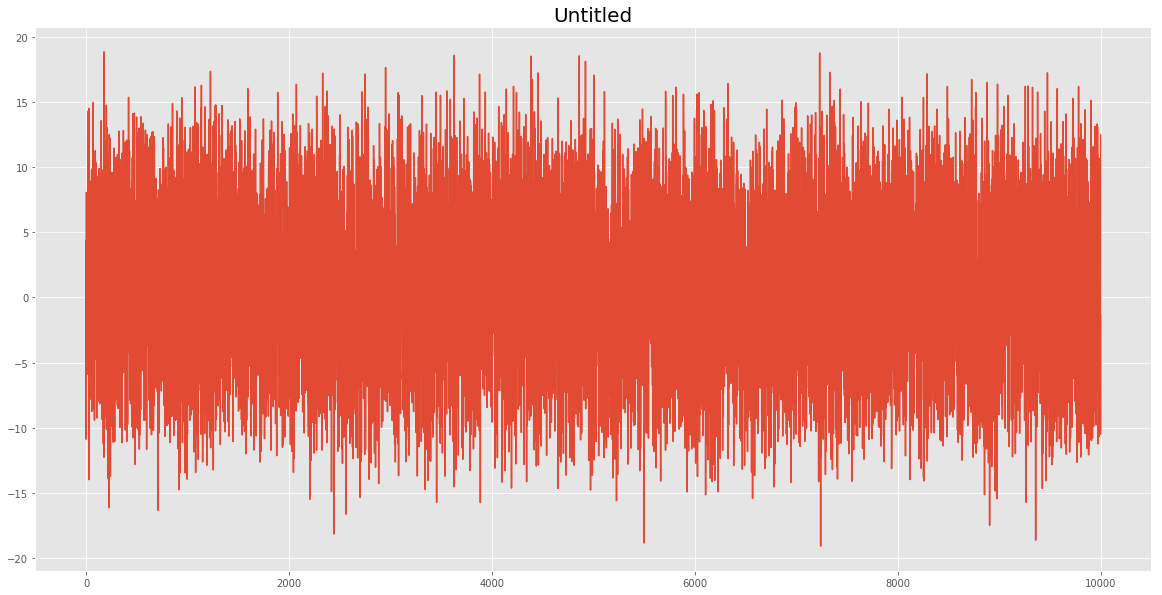

In [15]:
ez_plot(y)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123)

In [9]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
display(X_train.head())
display(y_train.head())
display(X_val.head())
display(y_val.head())

(7000, 289) (3000, 289) (7000,) (3000,)


,x1,x10,x100,x101,x102,x103,x104,x105,x106,x107,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
3144,10.021548,8.790670,42.610511,4.446050,19.036887,5.391952,52.258427,80.594438,10.279597,34.475335,...,9.233148,24.111816,41.769307,9.523762,5.059225,18.487219,6.806216,78.845146,22.702695,1.773789
9939,53.631012,2.162269,63.918283,13.805157,9.378115,18.330682,18.300622,6.942143,1.674581,28.848785,...,7.802811,34.220787,40.763355,18.522079,80.232064,25.878733,5.502256,19.871376,43.421059,49.183992
7925,6.807140,10.532437,19.784833,26.960105,13.752277,1.999764,0.964074,11.318114,0.318816,6.471286,...,40.095087,2.847769,13.171441,0.242236,40.440819,1.682898,52.441140,31.720507,18.684912,0.826305
309,4.533708,28.574653,31.956579,24.481457,2.300215,49.111099,7.753976,16.808884,52.492535,1.277497,...,11.275767,0.000000,6.963708,12.830505,63.347237,2.707664,91.571109,64.123030,8.425260,20.993886
9415,8.219606,9.698148,36.859585,55.190316,32.550111,12.182335,25.199393,61.270100,44.061983,1.713810,...,15.747254,21.090665,31.900419,17.440817,5.704974,2.572244,34.796094,4.839972,29.675535,7.495777


3144   -9.003491
9939    0.754535
7925   -8.633166
309     8.765171
9415   -0.409506
Name: value, dtype: float64

,x1,x10,x100,x101,x102,x103,x104,x105,x106,x107,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
2656,11.045821,23.740913,8.002167,22.885794,29.930354,55.657249,28.431925,46.708222,1.817977,29.227803,...,56.354581,6.630422,6.574834,4.631054,59.271684,2.173009,67.653785,69.703087,69.974020,6.507961
445,12.122570,53.920988,28.036541,48.012223,8.286254,4.102065,0.068125,4.266677,21.363176,6.531525,...,59.829719,57.840874,3.347485,53.823550,57.428348,23.709129,3.104188,16.623295,37.420808,66.806824
9505,0.000000,48.885376,0.554800,50.798444,5.886065,45.675000,27.697579,5.627069,6.483269,41.677405,...,55.431855,58.671770,27.142733,10.460948,36.763875,16.703589,68.632114,16.224384,60.245517,13.170628
332,27.179473,36.966937,38.456110,64.231806,1.699785,0.721519,33.615459,33.863222,55.462057,73.405849,...,19.344198,88.729506,39.840750,38.913588,11.414369,27.200892,4.215147,2.791769,4.173034,7.556770
4168,11.659946,12.493278,2.097167,45.117551,1.911299,21.249019,2.057454,4.719162,21.574440,52.308402,...,13.114812,16.834924,31.255312,58.896116,32.643529,56.714086,19.014555,15.586983,17.356070,32.695896


2656    -9.638218
445      2.417380
9505    -2.283908
332    -10.159383
4168   -11.310698
Name: value, dtype: float64

In [23]:
xgb_reg_bucket = XgbRegBucket()

In [24]:
uniform_weighting

<function __main__.uniform_weighting>

In [30]:
%%time

z = [evaluate_stacking(xgb_reg_bucket, uniform_weighting, x_val=X_val, y_val=y_val,
                       bucket_kwargs=dict(x=X_train, y=y_train),
                       metrics=[mean_squared_error], n_stack=50) for _ in range(10)]

CPU times: user 4min 48s, sys: 264 ms, total: 4min 48s
Wall time: 4min 48s


In [46]:
est = []
stack_results = []
n_stack=3
est_bucket = xgb_reg_bucket
bucket_kwargs=dict(x=X_train, y=y_train)
stacking_strategy = uniform_weighting
strategy_kwargs={}
metrics=[mean_squared_error]
x_val=X_val
y_val=y_val

In [47]:
for i in range(n_stack):
    est.append(est_bucket.draw(**bucket_kwargs))
    weighting = uniform_weighting(est, **strategy_kwargs)
    
    w_sum = sum(weighting)
    scores =  {f'{met.__name__}': sum([w * met(y_val, e.predict(x_val)) for w, e in zip(weighting, est)]) / w_sum for met in metrics}
    stack_results.append(scores)


In [51]:
est

[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=3, missing=None, n_estimators=5,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=0.8),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=3, missing=None, n_estimators=5,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=0.8),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=3, missing=None, n_estimators=5,
  

In [24]:
zz = pd.concat(z, axis=0)
display(zz)

,stk_1,stk_2,stk_3,stk_4,stk_5,stk_6,stk_7,stk_8,stk_9,stk_10,stk_11,stk_12,stk_13,stk_14,stk_15,stk_16,stk_17,stk_18,stk_19,stk_20
mean_squared_error,40.329690,40.366469,40.350434,40.357169,40.366788,40.375120,40.374954,40.353205,40.357507,40.367974,40.364936,40.363869,40.359531,40.361058,40.357540,40.356268,40.350704,40.347138,40.346219,40.346113
mean_squared_error,40.361678,40.350205,40.381003,40.397099,40.384950,40.375937,40.374574,40.377578,40.371201,40.366175,40.356863,40.349016,40.351462,40.352588,40.350967,40.342274,40.342482,40.340171,40.336710,40.337984
mean_squared_error,40.342868,40.344492,40.329548,40.346227,40.364093,40.372248,40.367154,40.366282,40.360774,40.373665,40.371084,40.377158,40.376280,40.381157,40.376853,40.377200,40.374650,40.368833,40.366200,40.370490
mean_squared_error,40.322559,40.392664,40.377963,40.377828,40.360798,40.354608,40.364069,40.361628,40.349777,40.347792,40.338311,40.343260,40.344911,40.335753,40.338914,40.337057,40.338442,40.336853,40.337835,40.338464
mean_squared_error,40.321466,40.302203,40.323437,40.331893,40.335574,40.332755,40.332361,40.325883,40.325339,40.324335,40.319473,40.319272,40.325492,40.326273,40.326064,40.329865,40.330004,40.331688,40.334007,40.335800
mean_squared_error,40.451087,40.443295,40.405977,40.396342,40.397059,40.394786,40.394549,40.389582,40.387221,40.382438,40.384790,40.373816,40.376844,40.369167,40.367029,40.358818,40.355203,40.355933,40.352676,40.348680
mean_squared_error,40.459830,40.395034,40.393044,40.381495,40.375953,40.354602,40.336231,40.338272,40.331672,40.329763,40.330758,40.327217,40.328616,40.322149,40.328324,40.325327,40.331017,40.331351,40.329233,40.326484
mean_squared_error,40.318284,40.320207,40.352804,40.359763,40.335584,40.348370,40.345299,40.344679,40.351520,40.352838,40.351830,40.355861,40.357066,40.352329,40.354240,40.358189,40.358532,40.361338,40.360247,40.352473
mean_squared_error,40.397590,40.369147,40.351785,40.357389,40.374378,40.361145,40.344901,40.336365,40.342069,40.336357,40.336307,40.338153,40.338018,40.334915,40.336371,40.329615,40.336177,40.336147,40.335652,40.337535
mean_squared_error,40.396356,40.362760,40.350615,40.347036,40.347533,40.340588,40.335537,40.336157,40.338780,40.344118,40.336388,40.340776,40.343504,40.343048,40.339675,40.342322,40.342568,40.344643,40.343986,40.342365


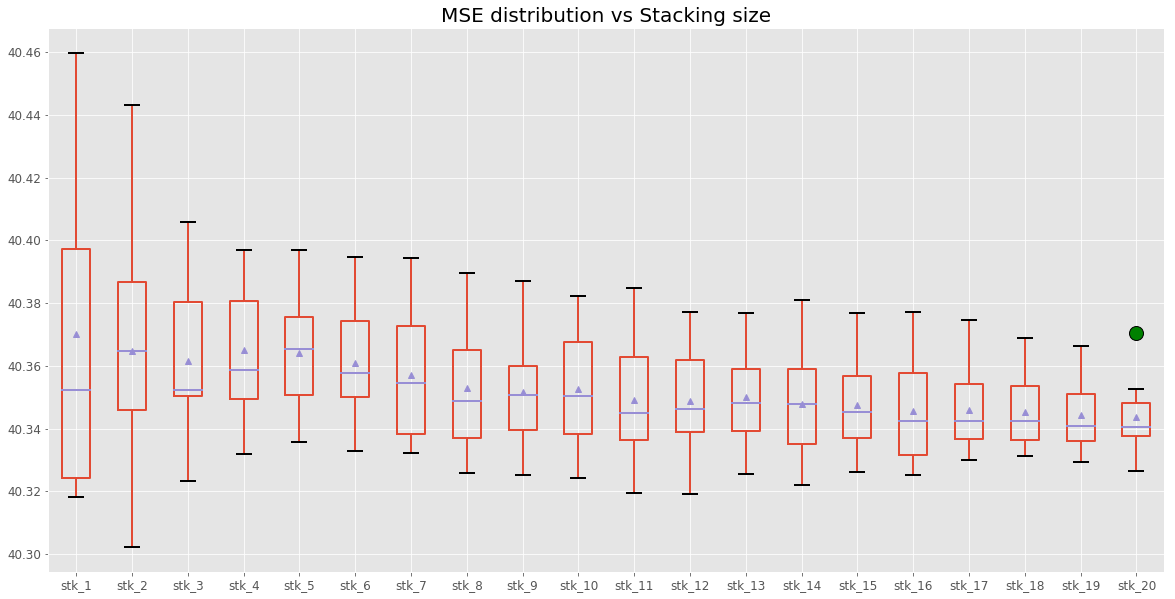

In [33]:
fig = ez_plot(zz, fontsize=12, kind='box', showmeans=True, title_prop={'label': 'MSE distribution vs Stacking size', 'size': 20},
        boxprops={'linewidth': 2, 'markerfacecolor': 'green'},
        whiskerprops={'linewidth': 2}, capprops={'linewidth': 2},
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        flierprops=dict(marker='o', markerfacecolor='green', markersize=14, linestyle='none'))
display(fig)

In [34]:
fig.savefig('static/stacking_experiment.jpg')

In [13]:
clf = LinearRegression()

In [14]:
est = clf.fit(X_train, y_train)

In [15]:
mean_squared_error(y_val, est.predict(X_val))

3.1681752512331864

In [45]:
Xb, yb = [df.reset_index(drop=True) for df in shuffle(X_train, y_train)]
Xb.head()

,x1,x10,x100,x101,x102,x103,x104,x105,x106,x107,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,10.996949,2.966602,0.000000,0.295665,47.849210,29.684104,2.629604,3.005389,20.744715,14.005343,...,37.923242,19.860352,30.971622,18.173474,23.013582,56.660997,17.565286,0.448294,21.000146,22.078119
1,31.220977,27.155837,15.614910,1.997781,0.000000,46.382066,1.020691,10.510288,34.126743,31.901401,...,31.085391,0.091961,29.206698,57.654528,37.055803,11.226421,24.808813,0.000000,7.555139,12.843214
2,25.905548,13.437753,5.784017,9.481668,39.881856,34.846901,7.294402,41.398559,16.462168,16.542345,...,47.305557,1.891158,19.762383,55.515028,4.393233,39.280161,12.157226,3.408932,0.000000,37.600971
3,27.302594,6.979013,3.877762,9.778110,47.074133,59.637416,5.471726,2.729827,8.290633,20.489187,...,9.479221,0.151404,25.890973,44.285670,43.867552,30.691893,40.491055,45.241682,30.537043,2.705684
4,1.461847,34.043117,1.690783,0.039451,2.955803,65.636995,44.303191,11.809424,42.540306,51.887067,...,10.255559,22.478938,0.534975,35.863165,9.343520,2.958321,9.971118,32.617233,59.763723,9.210663


In [46]:
clf = xgb_reg_bucket.draw()
est = clf.fit(Xb, yb)

mean_squared_error(y_val, est.predict(X_val))

59.301555740920421

In [39]:
mean_squared_error(y_val, est.predict(X_val))

59.282915569158341

In [65]:
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()


In [ ]:
ax.bxp()